<img src="img/ibidat.png" alt="drawing" width="600"/>

# Introducción

En este cuaderno vamos a probar todas las parejas posibles de métodos de fairness que afecten a distintas partes del proceso de la construcción del algoritmo de machine learning. Vamos a usar el dataset `homecredit`.

# Carga de librerías


In [1]:
# Con esta celda, podemos hacer cambios en cualquier script/libreria y verlo reflejado en las funciones del notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## CARGAMOS LIBRERIAS
# Obs: La primera vez puede tardar en cargar porque AIF360 pre-compila algunas cosas de tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargamos librerías de sklearn
# vanilla LR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Cargamos xgboost
from xgboost import XGBClassifier

# Cargamos algoritmos de fairness
# Pre-procesado
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
# In-procesado
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
# Post-procesado
from aif360.algorithms.postprocessing import RejectOptionClassification # when scores are given
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing # when scores (R) are given
from aif360.algorithms.postprocessing import EqOddsPostprocessing # when labels (Y^hat) are given
from aif360.datasets import GermanDataset

# TF para adversarial debiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from IPython.display import Markdown, display

# Librería local con funciones de ayuda extra
import utils

seed = 12345 # fijamos la semilla de números aleatorios para reproducir exactamante el notebook

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

# Selección de dataset.

El siguiente bloque permite seleccionar el conjunto de datos sobre el que trabajar. Debe recordarse que el conjunto de `homecredit` es mucho mayor por lo que tardará más tiempo en ejecutarse.


In [3]:
dataset_name = 'homecredit' # valid options are: german; homecredit

if dataset_name == 'german':
    dataset_german = GermanDataset(
        protected_attribute_names=['age'],            
        privileged_classes=[lambda x: x >= 25],      
        features_to_drop=['personal_status', 'sex'] 
    )
    

    # xgboost requiere que los labels empiecen en 0, y en este conjunto empiezan en 1
    # dataset_german.labels = dataset_german.labels - 1
    # dataset_german.favorable_label = dataset_german.favorable_label - 1
    # dataset_german.unfavorable_label = dataset_german.unfavorable_label - 1
    # cambiar los labels 2 a 0 (label 2 es desfavorabel y 1 es favorable) 
    dataset_german.labels[dataset_german.labels.ravel() == 2] =  dataset_german.labels[dataset_german.labels.ravel() == 2] - 2
    dataset_german.unfavorable_label = dataset_german.unfavorable_label - 2

    
    
    # Separamos el conjunto de datos en train, validate, test
    data_train, vt = dataset_german.split([0.7], shuffle=True, seed=seed)
    data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

    # Obtenemos los indicadores del grupo sensible
    sensitive_attribute = dataset_german.protected_attribute_names[0] # age
    privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset_german)
    
    print(f'Dimensiones del conjunto de datos: {dataset_german.features.shape}')
    print("Grupos privilegiados:", privileged_groups)
    print("Grupos no privilegiados:", unprivileged_groups)
    print("Label del grupo favorable:", dataset_german.favorable_label)
    print("Label del grupo desfavorable:", dataset_german.unfavorable_label) 
    
elif dataset_name == 'homecredit':
    dataset_homecredit = pd.read_csv('data/homecredit.zip', compression='zip', header=0, sep=',', quotechar='"')

    dataset_homecredit = utils.preprocess_homecredit(dataset_homecredit)

    dataset_homecredit_aif = utils.convert_to_standard_dataset(
            df=dataset_homecredit,
            target_label_name='TARGET',
            sensitive_attribute='AGE',
            priviledged_classes=[lambda x: x >= 25],
            favorable_target_label=[1],
            features_to_keep=[],
            categorical_features=[])

    # para hacer submuestra 
    sample_size_hc = 5000
    dataset_homecredit_aif = dataset_homecredit_aif.subset(np.random.randint(0, 307511+1, size=(sample_size_hc)))
    # Separamos el conjunto de datos en train, validate, test
    data_train, vt = dataset_homecredit_aif.split([0.7], shuffle=True, seed=seed)
    data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

    # Obtenemos los indicadores del grupo sensible
    sensitive_attribute = dataset_homecredit_aif.protected_attribute_names[0] # age
    privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset_homecredit_aif)

    print(f'Dimensiones del conjunto de datos: {dataset_homecredit_aif.features.shape}')
    print("Grupos privilegiados:", privileged_groups)
    print("Grupos no privilegiados:", unprivileged_groups)
    print("Label del grupo favorable:", dataset_homecredit_aif.favorable_label)
    print("Label del grupo desfavorable:", dataset_homecredit_aif.unfavorable_label) 
else:
    print('Invalid dataset selected')

/home/arturo_perez/DEFINITIVO/utils.py:1129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['AGE'] = -df['DAYS_BIRTH'].astype('float') / 365


Dimensiones del conjunto de datos: (5000, 226)
Grupos privilegiados: [{'AGE': 1.0}]
Grupos no privilegiados: [{'AGE': 0.0}]
Label del grupo favorable: 1.0
Label del grupo desfavorable: 0.0


## Modelos
Para esta sección, creamos un diccionario de métricas y modelos para poder acceder los resultados de todos los modelos.

In [4]:
# Inicializamos diccionarios
models = dict()

# Rango de umbrales para evaluar el score de los modelos
thresh_sweep = np.linspace(0.01, 1.0, 50)

metrics_sweep = dict()

# Store results from validation and test
metrics_best_thresh_validate = dict()
metrics_best_thresh_test = dict()

### Regresión Logística

In [5]:
%%time 

# Nombramos al modelo
model_name = 'logistic_regression'
fairness_method = ''

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

CPU times: user 1.58 s, sys: 3.46 s, total: 5.04 s
Wall time: 5.16 s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5905
Balanced accuracy: 0.5743
Accuracy: 0.6560
Independence ( |ΔP(Y_pred = 1)| ): 0.4534
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0086
Sufficiency ( |ΔPPV| ) : 0.0737
CPU times: user 25.9 s, sys: 28.4 s, total: 54.2 s
Wall time: 49.8 s


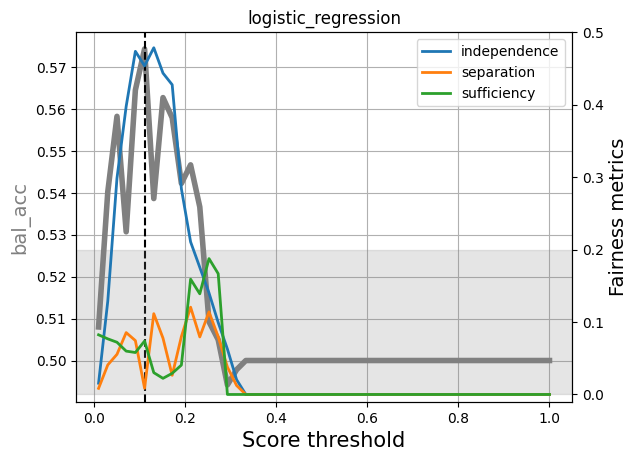

In [6]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [7]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.6014
Balanced accuracy: 0.5551
Accuracy: 0.6267
Independence ( |ΔP(Y_pred = 1)| ): 0.4831
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0573
Sufficiency ( |ΔPPV| ) : 0.0712


### XGBoost

In [8]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'
fairness_method = ''

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

CPU times: user 49min 10s, sys: 3.31 s, total: 49min 13s
Wall time: 2min 23s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.6950
Balanced accuracy: 0.6624
Accuracy: 0.6720
Independence ( |ΔP(Y_pred = 1)| ): 0.3159
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1294
Sufficiency ( |ΔPPV| ) : 0.0267
CPU times: user 25.9 s, sys: 24.9 s, total: 50.7 s
Wall time: 51.3 s


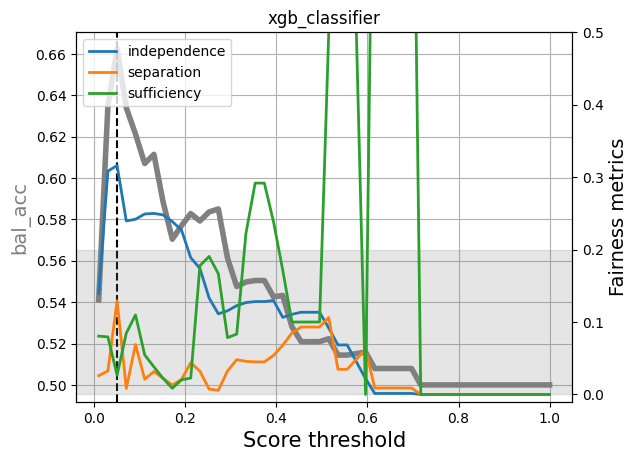

In [9]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


In [10]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.7024
Balanced accuracy: 0.6583
Accuracy: 0.6600
Independence ( |ΔP(Y_pred = 1)| ): 0.3347
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0329
Sufficiency ( |ΔPPV| ) : 0.0609


## Técnicas de preprocesado

### Reponderación

In [11]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit(data_train_copy)
data_train_REW = PreProcessor.transform(data_train_copy)
data_val_REW = PreProcessor.transform(data_val_copy)
data_test_REW = PreProcessor.transform(data_test_copy)

CPU times: user 3.03 s, sys: 2.54 s, total: 5.57 s
Wall time: 6.44 s


De aquí en adelante, se aplica el modelo de preferencia de manera estándar

### Eliminador de impacto dispar

In [12]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
nivel_reparacion = 0.5 # un valor 0 inidica ausencia de reparación (datos se mantienen igual) 
                       # un valor 1 indica reparación completa (se puede perder nivel predictivo).
                       # Se puede establecer cualquier valor entre 0 y 1.

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = DisparateImpactRemover(
    repair_level=nivel_reparacion,
    sensitive_attribute=sensitive_attribute
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit_transform(data_train_copy)
data_train_DIR = PreProcessor.fit_transform(data_train_copy)
data_val_DIR = PreProcessor.fit_transform(data_val_copy)
data_test_DIR = PreProcessor.fit_transform(data_test_copy)



CPU times: user 6.65 s, sys: 1.77 s, total: 8.42 s
Wall time: 9.42 s


## Entrenamiento de técnicas de inprocesado

Entrenamos ahora los algoritmos de inprocesado para aplicarlos posteriormente cuando hagan falta.

### Eliminador de prejuicios por regularización

In [13]:
%%time 
# Nombramos al modelo
model_name = 'prejudice_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [14]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

### Algoritmo de metafairness

In [15]:
%%time 
# Nombramos al modelo
model_name = 'meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )
    models[model_name_quality].scores_train = models[model_name_quality].predict(data_train_copy).scores
    models[model_name_quality].scores_val = models[model_name_quality].predict(data_val_copy).scores
    models[model_name_quality].scores_test = models[model_name_quality].predict(data_test_copy).scores

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_m

CPU times: user 9min 46s, sys: 10min 57s, total: 20min 43s
Wall time: 2min 11s


In [16]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for meta_fairness_sr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.4446
Balanced accuracy: 0.5000
Accuracy: 0.0840
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0836


Results for meta_fairness_fdr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.5561
Balanced accuracy: 0.5000
Accuracy: 0.0840
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0836


CPU times: user 55.2 s, sys: 1min 4s, total: 1min 59s
Wall time: 1min 53s


### Eliminación de prejuicios adversarios

In [17]:
%%time

# Nombramos al modelo
model_name = 'NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

2024-06-16 21:08:42.319491: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2024-06-16 21:08:42.743653: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 21612.150391; batch adversarial loss: 0.375354
epoch 1; iter: 0; batch classifier loss: 6635.577148; batch adversarial loss: 0.672253
epoch 2; iter: 0; batch classifier loss: 3012.795898; batch adversarial loss: 0.640447
epoch 3; iter: 0; batch classifier loss: 3332.253174; batch adversarial loss: 0.651522
epoch 4; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 5; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 6; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 7; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 8; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 9; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 10; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 11; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 12; iter: 0; batch classifier loss: nan; batch adve

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.5000
Balanced accuracy: 0.5000
Accuracy: 0.0840
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0836
CPU times: user 25.9 s, sys: 23.1 s, total: 49 s
Wall time: 1min 1s


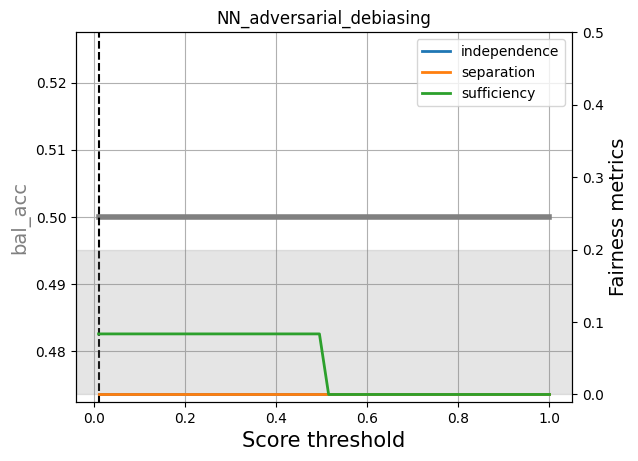

In [18]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

#### Eliminación de prejuicios adversarios: Red neuronal sin eliminación de prejuicios 

In [19]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'Basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

epoch 0; iter: 0; batch classifier loss: 12660.939453
epoch 1; iter: 0; batch classifier loss: 4463.670898
epoch 2; iter: 0; batch classifier loss: 2270.245850
epoch 3; iter: 0; batch classifier loss: 3453.479004
epoch 4; iter: 0; batch classifier loss: 2303.422363
epoch 5; iter: 0; batch classifier loss: 3438.271973
epoch 6; iter: 0; batch classifier loss: 2174.958008
epoch 7; iter: 0; batch classifier loss: 3667.432617
epoch 8; iter: 0; batch classifier loss: 763.788086
epoch 9; iter: 0; batch classifier loss: 2258.024170
epoch 10; iter: 0; batch classifier loss: 1485.894043
epoch 11; iter: 0; batch classifier loss: 1049.972900
epoch 12; iter: 0; batch classifier loss: 802.689575
epoch 13; iter: 0; batch classifier loss: 317.394501
epoch 14; iter: 0; batch classifier loss: 569.222290
epoch 15; iter: 0; batch classifier loss: 613.845581
epoch 16; iter: 0; batch classifier loss: 549.022827
epoch 17; iter: 0; batch classifier loss: 190.437668
epoch 18; iter: 0; batch classifier loss: 12

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496
CPU times: user 24.9 s, sys: 21 s, total: 45.9 s
Wall time: 1min 36s


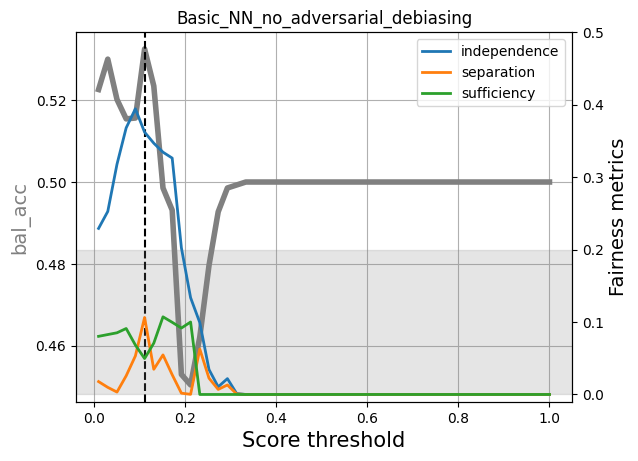

In [20]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Preprocesado + Inprocesado

### Reponderación + Eliminador de prejuicios

In [21]:
# Nombre del modelo
model_name = 'reweighting_prejudice_remover'

# Hacemos una copia de los datasets (usando uno de lo métodos de pre-procesado vistos anteriormente)
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [ ]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + Eliminador de prejuicios

In [ ]:
# Nombre del modelo
model_name = 'disparate_impact_prejudice_remover'

# Hacemos una copia de los datasets (usando uno de lo métodos de pre-procesado vistos anteriormente)
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

In [ ]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Reponderación + metafairness

In [22]:
%%time 
# Nombramos al modelo
model_name = 'reweighing_meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_m

CPU times: user 9min 31s, sys: 11min 4s, total: 20min 36s
Wall time: 2min 45s


In [23]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for reweighing_meta_fairness_sr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.4446
Balanced accuracy: 0.5000
Accuracy: 0.0825
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0071


Results for reweighing_meta_fairness_fdr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.5561
Balanced accuracy: 0.5000
Accuracy: 0.0825
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0071


CPU times: user 52.9 s, sys: 1min 15s, total: 2min 8s
Wall time: 1min 49s


### Impacto dispar + metafairness

In [24]:
%%time 
# Nombramos al modelo
model_name = 'disparate_impact_meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_m

CPU times: user 5min 46s, sys: 2min 57s, total: 8min 43s
Wall time: 22.1 s


In [25]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for disparate_impact_meta_fairness_sr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.4515
Balanced accuracy: 0.5000
Accuracy: 0.0840
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0836


Results for disparate_impact_meta_fairness_fdr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.5485
Balanced accuracy: 0.5000
Accuracy: 0.0840
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0836


CPU times: user 52 s, sys: 1min 9s, total: 2min 1s
Wall time: 1min 37s


### Reponderación + prejuicios adversarios

In [26]:
%%time

# Nombramos al modelo
model_name = 'reweighing_NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 85744.765625; batch adversarial loss: 0.355489
epoch 1; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 2; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 3; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 4; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 5; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 6; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 7; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 8; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 9; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 10; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 11; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 12; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 13; iter: 0; ba

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.5000
Balanced accuracy: 0.5000
Accuracy: 0.0825
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0071
CPU times: user 21.8 s, sys: 22.2 s, total: 44 s
Wall time: 44.3 s


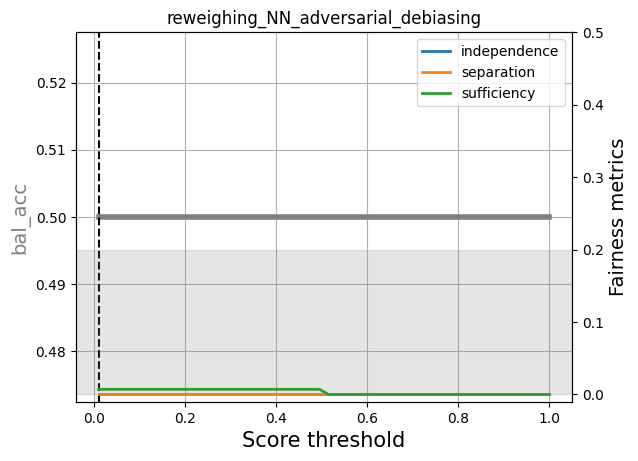

In [27]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Reponderación + red neuronal normal

In [28]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'reweighin_basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 7736.623047
epoch 1; iter: 0; batch classifier loss: 6388.323242
epoch 2; iter: 0; batch classifier loss: 2910.271973
epoch 3; iter: 0; batch classifier loss: 991.719666
epoch 4; iter: 0; batch classifier loss: 2987.678223
epoch 5; iter: 0; batch classifier loss: 1831.657593
epoch 6; iter: 0; batch classifier loss: 2024.812500
epoch 7; iter: 0; batch classifier loss: 816.734131
epoch 8; iter: 0; batch classifier loss: 476.979431
epoch 9; iter: 0; batch classifier loss: 719.677856
epoch 10; iter: 0; batch classifier loss: 477.012817
epoch 11; iter: 0; batch classifier loss: 398.159607
epoch 12; iter: 0; batch classifier loss: 456.880859
epoch 13; iter: 0; batch classifier loss: 527.483521
epoch 14; iter: 0; batch classifier loss: 196.302200
epoch 15; iter: 0; batch classifier loss: 370.473663
epoch 16; iter: 0; batch classifier loss: 141.409058
epoch 17; iter: 0; batch classifier loss: 157.371262
epoch 18; iter: 0; batch classifier loss: 74.19422

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5573
Balanced accuracy: 0.5520
Accuracy: 0.4511
Independence ( |ΔP(Y_pred = 1)| ): 0.2736
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0420
Sufficiency ( |ΔPPV| ) : 0.0050
CPU times: user 21.2 s, sys: 21 s, total: 42.2 s
Wall time: 42.8 s


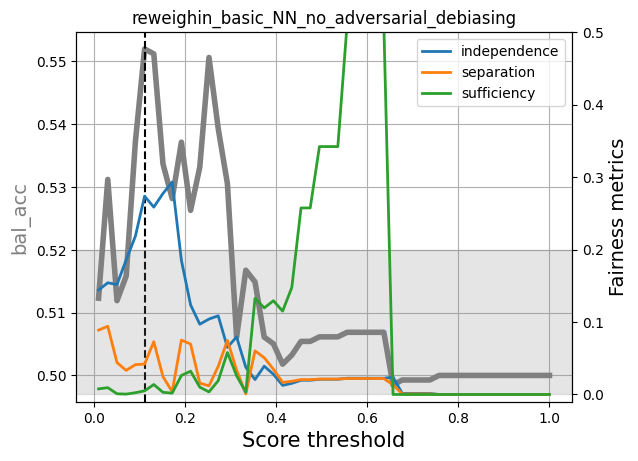

In [29]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + eliminación de prejuicios adversarios

In [30]:
%%time

# Nombramos al modelo
model_name = 'disparate_impact_NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 16907.234375; batch adversarial loss: 0.745006
epoch 1; iter: 0; batch classifier loss: 3743.965576; batch adversarial loss: 0.691745
epoch 2; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 3; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 4; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 5; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 6; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 7; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 8; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 9; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 10; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 11; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 12; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 13

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.5000
Balanced accuracy: 0.5000
Accuracy: 0.0840
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0836
CPU times: user 22 s, sys: 22.5 s, total: 44.4 s
Wall time: 44.4 s


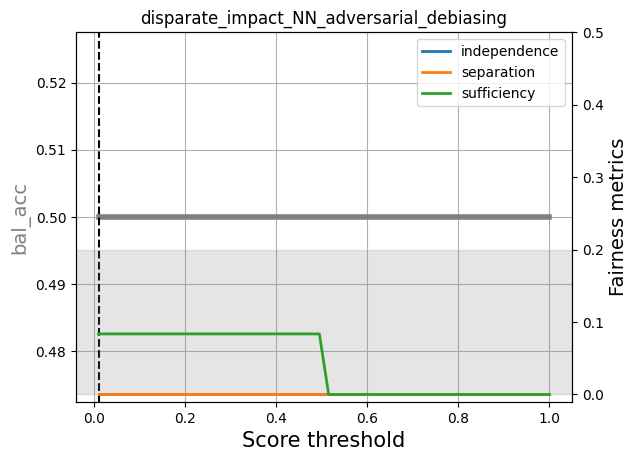

In [31]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + red neuronal normal

In [32]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'disparate_impact_basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 37784.117188
epoch 1; iter: 0; batch classifier loss: 9587.023438
epoch 2; iter: 0; batch classifier loss: 2543.201660
epoch 3; iter: 0; batch classifier loss: 4170.851074
epoch 4; iter: 0; batch classifier loss: 2304.241699
epoch 5; iter: 0; batch classifier loss: 4489.148438
epoch 6; iter: 0; batch classifier loss: 2466.798828
epoch 7; iter: 0; batch classifier loss: 2350.340820
epoch 8; iter: 0; batch classifier loss: 2828.186523
epoch 9; iter: 0; batch classifier loss: 1374.703369
epoch 10; iter: 0; batch classifier loss: 3711.144043
epoch 11; iter: 0; batch classifier loss: 2445.592285
epoch 12; iter: 0; batch classifier loss: 1196.741699
epoch 13; iter: 0; batch classifier loss: 1969.043091
epoch 14; iter: 0; batch classifier loss: 867.573486
epoch 15; iter: 0; batch classifier loss: 1045.606323
epoch 16; iter: 0; batch classifier loss: 922.423706
epoch 17; iter: 0; batch classifier loss: 613.977783
epoch 18; iter: 0; batch classifier loss

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0302
AUC: 0.5448
Balanced accuracy: 0.5477
Accuracy: 0.3827
Independence ( |ΔP(Y_pred = 1)| ): 0.0661
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1506
Sufficiency ( |ΔPPV| ) : 0.0362
CPU times: user 21.8 s, sys: 23.2 s, total: 44.9 s
Wall time: 45.2 s


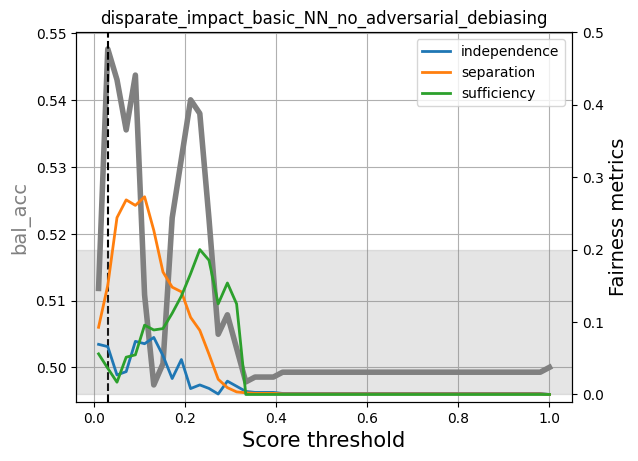

In [33]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Preprocesado + Postprocesado

### Entrenamiento de modelos con técnicas de preprocesado

#### Reponderación

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5919
Balanced accuracy: 0.5632
Accuracy: 0.6468
Independence ( |ΔP(Y_pred = 1)| ): 0.4239
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0852
Sufficiency ( |ΔPPV| ) : 0.0282


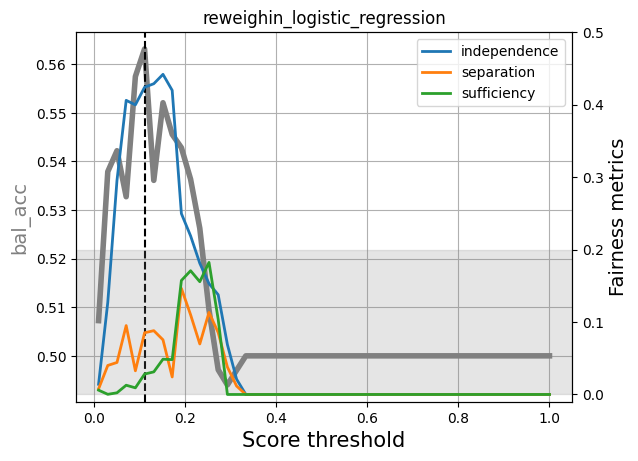

In [34]:
# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

# Regresión logística
model_name = 'reweighin_logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.6950
Balanced accuracy: 0.6599
Accuracy: 0.6704
Independence ( |ΔP(Y_pred = 1)| ): 0.3094
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1294
Sufficiency ( |ΔPPV| ) : 0.0583
CPU times: user 43min 56s, sys: 30.3 s, total: 44min 26s
Wall time: 2min 8s


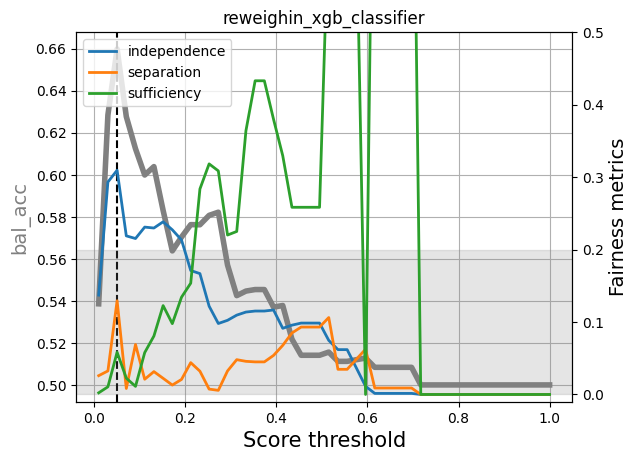

In [35]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

# Nombramos al modelo
model_name = 'reweighin_xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

#### Disparate impact

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0706
AUC: 0.5794
Balanced accuracy: 0.5646
Accuracy: 0.4400
Independence ( |ΔP(Y_pred = 1)| ): 0.1819
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1016
Sufficiency ( |ΔPPV| ) : 0.0549


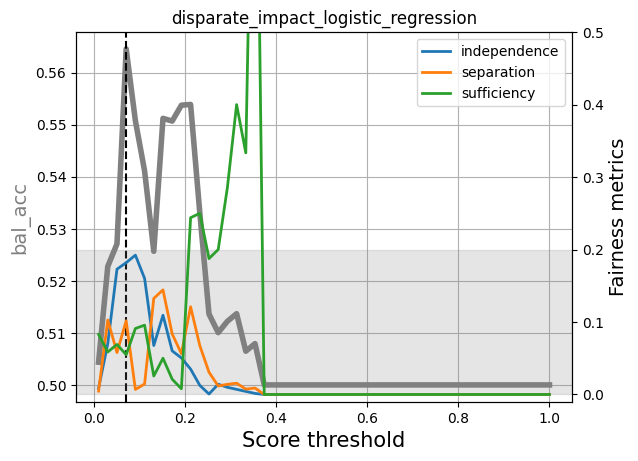

In [36]:
# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

# Regresión logística
model_name = 'disparate_impact_logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.6949
Balanced accuracy: 0.6565
Accuracy: 0.6613
Independence ( |ΔP(Y_pred = 1)| ): 0.1319
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0744
Sufficiency ( |ΔPPV| ) : 0.1468
CPU times: user 46min 22s, sys: 23.8 s, total: 46min 46s
Wall time: 1min 54s


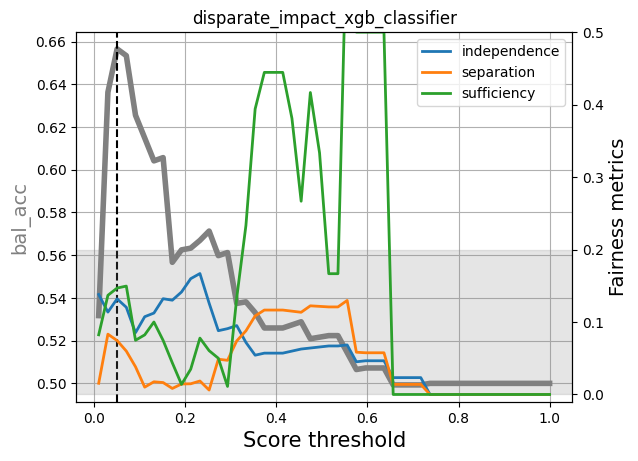

In [37]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

# Nombramos al modelo
model_name = 'disparate_impact_xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [38]:
#Anotamos los nombres de los modelos
model_names = ['reweighin_logistic_regression', 'reweighin_xgb_classifier', 'disparate_impact_logistic_regression', 'disparate_impact_xgb_classifier']

### Aplicación de técnicas de postprocesado 

#### Reponderación + Clasificación de rechazo de opción

In [39]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 33.4 s, sys: 13.9 s, total: 47.3 s
Wall time: 33 s


In [40]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

reweighin_logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.3763
AUC: 0.5919
Balanced accuracy: 0.5000
Accuracy: 0.9160
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000


reweighin_logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.3763
AUC: 0.5919
Balanced accuracy: 0.5000
Accuracy: 0.9160
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000


reweighin_logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.3763
AUC: 0.5919
Balanced accuracy: 0.5000
Accuracy: 0.9160
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000




In [41]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 36.3 s, sys: 2.43 s, total: 38.7 s
Wall time: 32.9 s


In [42]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

reweighin_xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.8118
AUC: 0.6950
Balanced accuracy: 0.5000
Accuracy: 0.9160
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000


reweighin_xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.6950
Balanced accuracy: 0.5813
Accuracy: 0.8933
Independence ( |ΔP(Y_pred = 1)| ): 0.2352
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0161
Sufficiency ( |ΔPPV| ) : 0.0726


reweighin_xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.1981
AUC: 0.6950
Balanced accuracy: 0.5813
Accuracy: 0.8933
Independence ( |ΔP(Y_pred = 1)| ): 0.2599
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0015
Sufficiency ( |ΔPPV| ) : 0.1026




#### Impacto dispar + Rechazo de opción

In [43]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 33.7 s, sys: 14.1 s, total: 47.8 s
Wall time: 33.3 s


In [44]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

disparate_impact_logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.1981
AUC: 0.5241
Balanced accuracy: 0.5199
Accuracy: 0.7280
Independence ( |ΔP(Y_pred = 1)| ): 0.0008
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0820
Sufficiency ( |ΔPPV| ) : 0.0030


disparate_impact_logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.6534
AUC: 0.5241
Balanced accuracy: 0.5000
Accuracy: 0.9160
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000


disparate_impact_logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.6534
AUC: 0.5241
Balanced accuracy: 0.5000
Accuracy: 0.9160
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000




In [45]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 36.7 s, sys: 2.28 s, total: 39 s
Wall time: 33.1 s


In [46]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

disparate_impact_xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.8415
AUC: 0.6952
Balanced accuracy: 0.5000
Accuracy: 0.9160
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000


disparate_impact_xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.5148
AUC: 0.6952
Balanced accuracy: 0.5296
Accuracy: 0.9173
Independence ( |ΔP(Y_pred = 1)| ): 0.0641
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1126
Sufficiency ( |ΔPPV| ) : 0.1667


disparate_impact_xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.0496
AUC: 0.6952
Balanced accuracy: 0.6316
Accuracy: 0.7080
Independence ( |ΔP(Y_pred = 1)| ): 0.3739
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0930
Sufficiency ( |ΔPPV| ) : 0.0306




#### Reponderación y impacto dispar + Escalado de Platt por grupos

In [47]:
%%time
fairness_method = '_platt_scaling'
model_names = model_names
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)

for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name], class_thresh = model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                             'unpriv': [data_val_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data.items():

        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()

        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                  data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        
        # Evaluamos a los modelos para el rango de umbrales
    thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                     np.max(data_val_preds2.scores.ravel()),
                                     50)

    metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores(
            dataset_true = data_val_copy,
            dataset_preds = data_val_preds2,
            thresh_arr = thresh_sweep_platt
        )

    # Evaluamos las métricas para el mejor umbral y las guardamos
    metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    print('\nValidation set results for {}'.format(model_name))
    utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
    # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
    # plt.title( model_name+fairness_method )
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
    a.set_title(model_name+fairness_method )
    f



Validation set results for reweighin_logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.0805
AUC: 0.6043
Balanced accuracy: 0.5750
Accuracy: 0.6440
Independence ( |ΔP(Y_pred = 1)| ): 0.6846
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0614
Sufficiency ( |ΔPPV| ) : 0.0552

Validation set results for reweighin_xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.0785
AUC: 0.6915
Balanced accuracy: 0.6415
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.7129
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1350
Sufficiency ( |ΔPPV| ) : 0.0150

Validation set results for disparate_impact_logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.1608
AUC: 0.5138
Balanced accuracy: 0.5301
Accuracy: 0.8787
Independence ( |ΔP(Y_pred = 1)| ): 0.9767
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0139
Sufficiency ( |ΔPPV| ) : 0.1667

Validation set results for disparate_impact_xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.0753
AUC: 0.6890
Balanced

In [48]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name], class_thresh = model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

#### Reponderación + Procesador de probabilidades igualadas

##### Usando labels

In [49]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [50]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [51]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [52]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [53]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 7.42 s, sys: 17.5 s, total: 24.9 s
Wall time: 6.66 s


In [54]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for reweighin_logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5919
Balanced accuracy: 0.5707
Accuracy: 0.6493
Independence ( |ΔP(Y_pred = 1)| ): 0.4217
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0852
Sufficiency ( |ΔPPV| ) : 0.0466


Results for reweighin_logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5919
Balanced accuracy: 0.5800
Accuracy: 0.6400
Independence ( |ΔP(Y_pred = 1)| ): 0.6775
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0673
Sufficiency ( |ΔPPV| ) : 0.0531


Results for reweighin_logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5919
Balanced accuracy: 0.5707
Accuracy: 0.6493
Independence ( |ΔP(Y_pred = 1)| ): 0.4217
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0852
Sufficiency ( |ΔPPV| ) : 0.0466




In [55]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 8.75 s, sys: 3.68 s, total: 12.4 s
Wall time: 6.77 s


In [56]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for reweighin_xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.6950
Balanced accuracy: 0.5653
Accuracy: 0.8507
Independence ( |ΔP(Y_pred = 1)| ): 0.3352
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1346
Sufficiency ( |ΔPPV| ) : 0.1252


Results for reweighin_xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.6950
Balanced accuracy: 0.6616
Accuracy: 0.6707
Independence ( |ΔP(Y_pred = 1)| ): 0.3392
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1432
Sufficiency ( |ΔPPV| ) : 0.0205


Results for reweighin_xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.6950
Balanced accuracy: 0.5667
Accuracy: 0.8533
Independence ( |ΔP(Y_pred = 1)| ): 0.3380
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1331
Sufficiency ( |ΔPPV| ) : 0.1199




#### Impacto dispar + Procesador de probabilidades igualadas

##### Usando labels

In [57]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [58]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [59]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [60]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

##### Usando scores

In [61]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 7.62 s, sys: 17.8 s, total: 25.4 s
Wall time: 6.85 s


In [62]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for disparate_impact_logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.1514
AUC: 0.5241
Balanced accuracy: 0.5341
Accuracy: 0.6747
Independence ( |ΔP(Y_pred = 1)| ): 0.2463
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0057
Sufficiency ( |ΔPPV| ) : 0.0808


Results for disparate_impact_logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.1514
AUC: 0.5241
Balanced accuracy: 0.5461
Accuracy: 0.7760
Independence ( |ΔP(Y_pred = 1)| ): 0.3708
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0151
Sufficiency ( |ΔPPV| ) : 0.0618


Results for disparate_impact_logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.1514
AUC: 0.5241
Balanced accuracy: 0.5341
Accuracy: 0.6747
Independence ( |ΔP(Y_pred = 1)| ): 0.2463
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0057
Sufficiency ( |ΔPPV| ) : 0.0808




In [63]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 8.02 s, sys: 3.4 s, total: 11.4 s
Wall time: 7.57 s


In [64]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for disparate_impact_xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.6952
Balanced accuracy: 0.5410
Accuracy: 0.8987
Independence ( |ΔP(Y_pred = 1)| ): 0.3812
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1788
Sufficiency ( |ΔPPV| ) : 0.0941


Results for disparate_impact_xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.0302
AUC: 0.6952
Balanced accuracy: 0.6567
Accuracy: 0.5560
Independence ( |ΔP(Y_pred = 1)| ): 0.3676
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0550
Sufficiency ( |ΔPPV| ) : 0.0679


Results for disparate_impact_xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.0302
AUC: 0.6952
Balanced accuracy: 0.5485
Accuracy: 0.2520
Independence ( |ΔP(Y_pred = 1)| ): 0.0022
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0694
Sufficiency ( |ΔPPV| ) : 0.1133




## Inprocesado + Postprocesado

In [65]:
#Anotamos los nombres de los modelos que vamos a usar
model_names = ['prejudice_remover', 'meta_fairness_sr', 'meta_fairness_fdr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']

### Eliminador de prejuicios + rechazo de opción

In [66]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

In [67]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

KeyError: 'prejudice_remover_reject_option_spd'

### Metafairness + rechazo de opción

In [68]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 38.7 s, sys: 1.46 s, total: 40.1 s
Wall time: 1min 1s


In [69]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

meta_fairness_sr_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.8415
AUC: 0.6952
Balanced accuracy: 0.5000
Accuracy: 0.9160
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000


meta_fairness_sr_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.5148
AUC: 0.6952
Balanced accuracy: 0.5296
Accuracy: 0.9173
Independence ( |ΔP(Y_pred = 1)| ): 0.0641
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1126
Sufficiency ( |ΔPPV| ) : 0.1667


meta_fairness_sr_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.0496
AUC: 0.6952
Balanced accuracy: 0.6316
Accuracy: 0.7080
Independence ( |ΔP(Y_pred = 1)| ): 0.3739
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0930
Sufficiency ( |ΔPPV| ) : 0.0306




### Prejuicios adversarios + rechazo de opción

In [70]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 38.7 s, sys: 1.93 s, total: 40.7 s
Wall time: 1min


In [71]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

meta_fairness_fdr_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.8415
AUC: 0.6952
Balanced accuracy: 0.5000
Accuracy: 0.9160
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000


meta_fairness_fdr_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.5148
AUC: 0.6952
Balanced accuracy: 0.5296
Accuracy: 0.9173
Independence ( |ΔP(Y_pred = 1)| ): 0.0641
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1126
Sufficiency ( |ΔPPV| ) : 0.1667


meta_fairness_fdr_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.0496
AUC: 0.6952
Balanced accuracy: 0.6316
Accuracy: 0.7080
Independence ( |ΔP(Y_pred = 1)| ): 0.3739
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0930
Sufficiency ( |ΔPPV| ) : 0.0306




### Red neuronal normal + rechazo de opción

In [72]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 39.9 s, sys: 2.03 s, total: 42 s
Wall time: 58.5 s


In [73]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

NN_adversarial_debiasing_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.8415
AUC: 0.6952
Balanced accuracy: 0.5000
Accuracy: 0.9160
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000


NN_adversarial_debiasing_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.5148
AUC: 0.6952
Balanced accuracy: 0.5296
Accuracy: 0.9173
Independence ( |ΔP(Y_pred = 1)| ): 0.0641
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1126
Sufficiency ( |ΔPPV| ) : 0.1667


NN_adversarial_debiasing_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.0496
AUC: 0.6952
Balanced accuracy: 0.6316
Accuracy: 0.7080
Independence ( |ΔP(Y_pred = 1)| ): 0.3739
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0930
Sufficiency ( |ΔPPV| ) : 0.0306




### Inprocesado + Escalado Platt por grupos

In [74]:
%%time
fairness_method = '_platt_scaling'

model_names = ['NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
#model_names = ['meta_fairness_fdr', 'meta_fairness_sr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
#model_names = ['prejudice_remover', 'meta_fairness_sr', 'meta_fairness_fdr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)
    
for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                            'unpriv': [data_val_preds_unpriv, unpriv_indices]}
    
    for group, data_group_list in sensitive_groups_data.items():
    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)
    
        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()
    
        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                      data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
            
        # Evaluamos a los modelos para el rango de umbrales
        thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                         np.max(data_val_preds2.scores.ravel()),
                                         50)
    
        metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores(
                dataset_true = data_val_copy,
                dataset_preds = data_val_preds2,
                thresh_arr = thresh_sweep_platt
            )
    
        # Evaluamos las métricas para el mejor umbral y las guardamos
        metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )
    
        # Graficamos el comportamiento del modelo para el rango de umbrales 
        print('\nValidation set results for {}'.format(model_name))
        utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
        # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
        # plt.title( model_name+fairness_method )
        
        f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
        a.set_title(model_name+fairness_method )
        f

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [75]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### Eliminador de prejuicios + Procesador de probabilidades igualadas

##### Usando labels

In [ ]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

In [ ]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

#### Usando scores

In [ ]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

In [ ]:
display(Markdown("**Validation set results for prejudice remover**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

#### Metafairness + Procesador de probabilidades igualadas

##### Usando labels

In [76]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

2024-06-16 21:51:41.627312: W tensorflow/c/c_api.cc:305] Operation '{name:'biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Assign' id:264 op device:{requested: '', assigned: ''} def:{{{node biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](biased_classifier/biased_classifier/classifier_model/b2/Adam_1, biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [77]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [78]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 5.36 s, sys: 4.23 s, total: 9.58 s
Wall time: 9.8 s


In [79]:
display(Markdown("**Validation set results for metafairness**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for metafairness**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496




##### Usando labels

In [80]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [81]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [82]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [83]:
display(Markdown("**Validation set results for metafairness**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for metafairness**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496




#### Prejuicios adversarios + Procesador de probabilidades igualadas

##### Usando labels

In [84]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [85]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [86]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [87]:
display(Markdown("**Validation set results for adversarial debiasing**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for adversarial debiasing**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496




#### Red neuronal normal + Procesador de probabilidades igualadas

##### Usando labels

In [88]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[4]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [89]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [90]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[4]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [91]:
display(Markdown("**Validation set results for basic NN**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for basic NN**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.1110
AUC: 0.5062
Balanced accuracy: 0.5325
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1062
Sufficiency ( |ΔPPV| ) : 0.0496




## Comparación de modelos

Podemos usar los diccionarios que resumen la calidad de los modelos fair para compararlos todos.

### Resultados en validación

In [92]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_validate).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.111020,0.574340,0.656000,0.453439,0.008641,0.073710,0.590536
xgb_classifier,0.050408,0.662369,0.672000,0.315944,0.129352,0.026673,0.695016
meta_fairness_sr,0.010000,0.500000,0.084000,0.000000,0.000000,0.083583,0.444560
meta_fairness_fdr,0.010000,0.500000,0.084000,0.000000,0.000000,0.083583,0.556087
NN_adversarial_debiasing,0.010000,0.500000,0.084000,0.000000,0.000000,0.083583,0.500000
Basic_NN_no_adversarial_debiasing,0.111020,0.532508,0.513333,0.361962,0.106247,0.049603,0.506204
reweighing_meta_fairness_sr,0.010000,0.500000,0.082511,0.000000,0.000000,0.007136,0.444560
reweighing_meta_fairness_fdr,0.010000,0.500000,0.082511,0.000000,0.000000,0.007136,0.556087
disparate_impact_meta_fairness_sr,0.010000,0.500000,0.084000,0.000000,0.000000,0.083583,0.451515
disparate_impact_meta_fairness_fdr,0.010000,0.500000,0.084000,0.000000,0.000000,0.083583,0.548532


### Resultados en test

In [93]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_test).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.111020,0.555075,0.626667,0.483117,0.057343,0.071199,0.601426
xgb_classifier,0.050408,0.658300,0.660000,0.334665,0.032884,0.060923,0.702419
meta_fairness_sr,0.010000,0.500000,0.085333,0.000000,0.000000,0.060340,0.471870
meta_fairness_fdr,0.010000,0.500000,0.085333,0.000000,0.000000,0.060340,0.528631
NN_adversarial_debiasing,0.010000,0.500000,0.085333,0.000000,0.000000,0.060340,0.500000
Basic_NN_no_adversarial_debiasing,0.111020,0.533118,0.534667,0.255544,0.022897,0.068537,0.555006
reweighing_meta_fairness_sr,0.010000,0.500000,0.085145,0.000000,0.000000,0.008044,0.471870
reweighing_meta_fairness_fdr,0.010000,0.500000,0.085145,0.000000,0.000000,0.008044,0.528631
disparate_impact_meta_fairness_sr,0.010000,0.500000,0.085333,0.000000,0.000000,0.060340,0.466837
disparate_impact_meta_fairness_fdr,0.010000,0.500000,0.085333,0.000000,0.000000,0.060340,0.533254


In [94]:
algorithm_performance_summary.to_csv('PERFORMANCE_HOMECREDIT_MULTALG', index = True, sep=',', encoding='utf-8')